#1.**Introduction**

This project aims to develop a movie recommendation system. The system will utilize machine learning techniques to provide personalized movie suggestions based on user ratings and tags. The dataset used for this project is the MovieLens dataset, which contains ratings, tags, movie metadata and links.

#2.**Business** **Understanding**

##Objectives


1)   Personalised movie recommendations based on users history

2)   Investigate how the system performs for new users and new movies (analysis of the cold start problem)

3)   Build a deep learning based model that learns from user ratings and movie features to improve recommendation accuracy

4)   Optimize recommendation algorithms

5)   A dashboard to explore recommendations and engagement insights.






#3.**Data Undestanding**

##Libraries

In [96]:
# Import neccesary Libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer

# pip install scikit-surprise
# conda install -c conda-forge scikit-surprise

from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise import KNNBasic
from surprise import SVD
from surprise.model_selection import train_test_split



##Import Datasets

In [97]:
# Load data
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
print(f"Movies: {movies.shape}")
print(f"Ratings: {ratings.shape}")
print(f"Tags: {tags.shape}")

Movies: (9742, 3)
Ratings: (100836, 4)
Tags: (3683, 4)


In [98]:
print(movies.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [99]:
print(ratings.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [100]:
print(tags.head())

   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200


In [101]:
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


In [102]:
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


In [103]:
print(tags.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None


#4.**Data Cleaning**

##Correct Formats

In [104]:
# Confirming the format of individual columns
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


##Confirming Mising values

In [105]:
#Confirming whether there are missing values
print(movies.isnull().sum())
print(ratings.isnull().sum())
print(tags.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


##Merging the datasets

In [106]:
# Merging the datasets into a common dataset
movie_data = pd.merge(movies, ratings, on='movieId', how='outer')
movie_data = pd.merge(movie_data, tags, on=['userId', 'movieId'], how='outer')
print(movie_data.head())

   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating   timestamp_x  tag  timestamp_y  
0     1.0     4.0  9.649827e+08  NaN          NaN  
1     5.0     4.0  8.474350e+08  NaN          NaN  
2     7.0     4.5  1.106636e+09  NaN          NaN  
3    15.0     2.5  1.510578e+09  NaN          NaN  
4    17.0     4.5  1.305696e+09  NaN          NaN  


## Checking Duplicates

In [107]:
#Checking for duplicates in the movies_data.
#There were no duplicates in the dataset
movie_data.duplicated().sum()

0

##Exploratory Data Analysis(EDA)

In [108]:
print(movie_data.shape)

(102902, 8)


In [109]:
#Separate the timestamp column into date and year
movie_data['date'] = pd.to_datetime(movie_data['timestamp_x'], unit='s').dt.date
movie_data['year'] = pd.to_datetime(movie_data['timestamp_x'], unit='s').dt.year
movie_data.head()

,movieId,title,genres,userId,rating,timestamp_x,tag,timestamp_y,date,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08,NaN,NaN,2000-07-30,2000.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08,NaN,NaN,1996-11-08,1996.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09,NaN,NaN,2005-01-25,2005.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09,NaN,NaN,2017-11-13,2017.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09,NaN,NaN,2011-05-18,2011.0


In [110]:
print(movie_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102902 entries, 0 to 102901
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   movieId      102902 non-null  int64  
 1   title        102695 non-null  object 
 2   genres       102695 non-null  object 
 3   userId       102884 non-null  float64
 4   rating       102677 non-null  float64
 5   timestamp_x  102677 non-null  float64
 6   tag          3683 non-null    object 
 7   timestamp_y  3683 non-null    float64
 8   date         102677 non-null  object 
 9   year         102677 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 8.6+ MB
None


In [111]:
print(movie_data.describe())

             movieId         userId         rating   timestamp_x  \
count  102902.000000  102884.000000  102677.000000  1.026770e+05   
mean    19731.937844     328.016028       3.514813  1.209495e+09   
std     35868.440724     183.158345       1.043133  2.170117e+08   
min         1.000000       1.000000       0.500000  8.281246e+08   
25%      1199.000000     177.000000       3.000000  1.019138e+09   
50%      3006.000000     330.000000       3.500000  1.186590e+09   
75%      8364.000000     477.000000       4.000000  1.439916e+09   
max    193609.000000     610.000000       5.000000  1.537799e+09   

        timestamp_y           year  
count  3.683000e+03  102677.000000  
mean   1.320032e+09    2007.837461  
std    1.721025e+08       6.915344  
min    1.137179e+09    1996.000000  
25%    1.137521e+09    2002.000000  
50%    1.269833e+09    2007.000000  
75%    1.498457e+09    2015.000000  
max    1.537099e+09    2018.000000  


In [112]:
# Checking for unique values in the dataset
for col in movie_data.columns:
    print(f"Unique values in column '{col}': {movie_data[col].nunique()}")

Unique values in column 'movieId': 9742
Unique values in column 'title': 9737
Unique values in column 'genres': 951
Unique values in column 'userId': 610
Unique values in column 'rating': 10
Unique values in column 'timestamp_x': 85043
Unique values in column 'tag': 1589
Unique values in column 'timestamp_y': 3411
Unique values in column 'date': 4110
Unique values in column 'year': 23


In [113]:
movie_data.isnull().sum()

movieId            0
title            207
genres           207
userId            18
rating           225
timestamp_x      225
tag            99219
timestamp_y    99219
date             225
year             225
dtype: int64

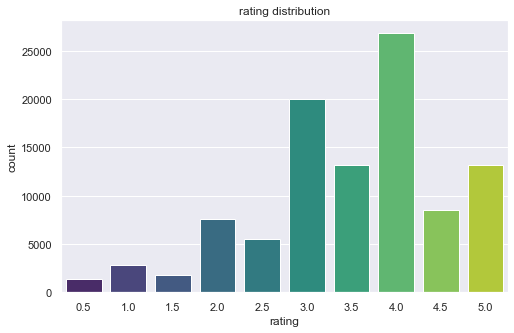

In [114]:
#Rating distribution
plt.figure(figsize=(8,5))
sns.countplot(data=ratings, x='rating', palette='viridis')
plt.title('rating distribution')
plt.xlabel('rating')
plt.ylabel('count')
plt.show()

In [115]:
# Average Rating per Movie
movie_stats = ratings.groupby('movieId').agg(avg_rating=('rating', 'mean'),
                                              num_ratings=('rating', 'count')).reset_index()

# Merge with movies
movie_stats = movie_stats.merge(movies, on='movieId')

# Filter movies with at least 100 ratings
top_rated = movie_stats[movie_stats['num_ratings'] >= 100]
top_rated = top_rated.sort_values('avg_rating', ascending=False).head(10)

print("\nTop Rated Movies (min 100 ratings):")
display(top_rated[['title', 'avg_rating', 'num_ratings']])


Top Rated Movies (min 100 ratings):


,title,avg_rating,num_ratings
277,"Shawshank Redemption, The (1994)",4.429022,317
659,"Godfather, The (1972)",4.289062,192
2224,Fight Club (1999),4.272936,218
921,"Godfather: Part II, The (1974)",4.259690,129
6298,"Departed, The (2006)",4.252336,107
913,Goodfellas (1990),4.250000,126
694,Casablanca (1942),4.240000,100
6693,"Dark Knight, The (2008)",4.238255,149
46,"Usual Suspects, The (1995)",4.237745,204
898,"Princess Bride, The (1987)",4.232394,142


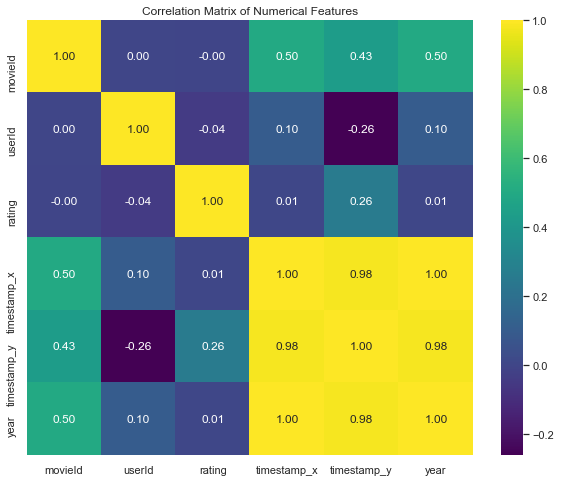

In [116]:
# Heatmap of Correlation Matrix (if numerical columns exist)
numerical_cols = movie_data.select_dtypes(include=np.number).columns
plt.figure(figsize=(10, 8))
sns.heatmap(movie_data[numerical_cols].corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

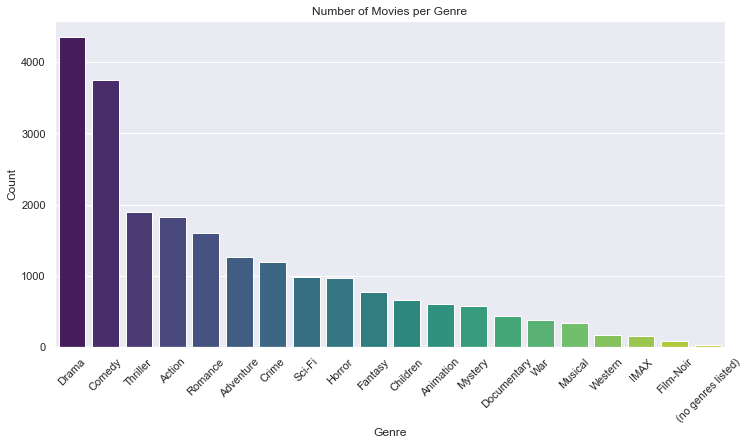

In [117]:
# Genre Analysis
# Split genres into individual genre rows
genre_counts = movies['genres'].str.split('|').explode().value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

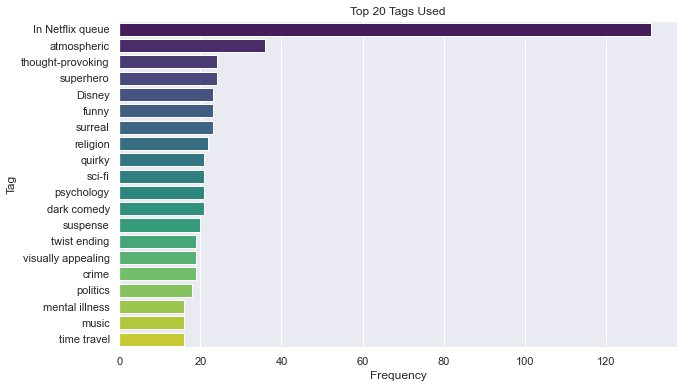

In [118]:
#Tag Frequency
top_tags = tags['tag'].value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_tags.values, y=top_tags.index, palette='viridis')
plt.title('Top 20 Tags Used')
plt.xlabel('Frequency')
plt.ylabel('Tag')
plt.show()


# Data Preprocessing


#Handling NaNs
We begib by handling nans in our columns

In [119]:
movie_data.isnull().sum()

movieId            0
title            207
genres           207
userId            18
rating           225
timestamp_x      225
tag            99219
timestamp_y    99219
date             225
year             225
dtype: int64

In [120]:
#replace missing values
movie_data['title'] = movie_data['title'].astype(str).fillna('')
movie_data['tag'] = movie_data['tag'].astype(str).fillna('')
movie_data['genres'] = movie_data['genres'].astype(str).fillna('')
movie_data['rating'] = movie_data['rating'].fillna(movie_data['rating'].mean())
movie_data = movie_data.dropna(subset=['userId'])

## Encoding
In this step we will encode categorical columns movieid, title, genres, userid, tag into numerical formats.
Then we handle the multilabel column genres

1st we handle movieid, userid.We encode them into sequential integer indices This code will transform user and movie IDs into consistent encoded IDs like 0,1,2,3,4,5

In [121]:
#movieid and userid
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

movie_data['userId_encoded'] = user_encoder.fit_transform(movie_data['userId'])
movie_data['movieId_encoded'] = movie_encoder.fit_transform(movie_data['movieId'])

2nd we perform TF-IDF on the title and tag columns. This will convert text into numeric vectors that reflect how important each word is

In [122]:
#title and Tags
tfidf = TfidfVectorizer(max_features=100)
title_tfidf = tfidf.fit_transform(movie_data['title']).toarray()

tag_vectorizer = TfidfVectorizer(max_features=100)
tag_tfidf = tag_vectorizer.fit_transform(movie_data['tag'].fillna('')).toarray()



3rd we handle the genres column which is multi-label which means one movie can belong to more than one genre, we will convert it into multi-hot encoding

In [123]:
#Fill NaNs and split genres
movie_data['genres'] = movie_data['genres'].astype(str).fillna('')

#Get all unique genres
all_genres = set(g for genre_list in movie_data['genres'] for g in genre_list)

#Create binary columns for each genre
for genre in all_genres:
    movie_data[f'genre_{genre}'] = movie_data['genres'].apply(lambda x: int(genre in x))


##Standardization
We normalize the numerical column rating.


In [124]:
scaler = MinMaxScaler()
movie_data['rating_normalized'] = scaler.fit_transform(movie_data[['rating']])

In [125]:
movie_data.head()

,movieId,title,genres,userId,rating,timestamp_x,tag,timestamp_y,date,year,...,genre_|,genre_n,genre_s,genre_r,genre_i,genre_m,genre_H,genre_e,genre_h,rating_normalized
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08,nan,NaN,2000-07-30,2000.0,...,1,1,1,1,1,1,0,1,1,0.777778
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08,nan,NaN,1996-11-08,1996.0,...,1,1,1,1,1,1,0,1,1,0.777778
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09,nan,NaN,2005-01-25,2005.0,...,1,1,1,1,1,1,0,1,1,0.888889
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09,nan,NaN,2017-11-13,2017.0,...,1,1,1,1,1,1,0,1,1,0.444444
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09,nan,NaN,2011-05-18,2011.0,...,1,1,1,1,1,1,0,1,1,0.888889


# Modeling

In [126]:
movie_data_processed = movie_data

We shall start with KNN model as our baseline. The idea behind KNN is it assumes that similar things are usually close together. Since recommendation systems are all about finding and using those similarities, we thought this would be a solid place to start our analysis.

In [127]:
# Create a Reader object to define the format
reader = Reader(rating_scale=(0.5, 5.0))

# Load the dataset into Surprise format
data = Dataset.load_from_df(movie_data_processed[['userId', 'movieId', 'rating']], reader)

Splitting the data using 80/20 split

In [128]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

To address the cold start problem, let us first use the content based filtering first using KNNBasic

In [129]:
# Item-based collaborative filtering (can also use item-based with sim_options)
sim_options = {
    'name': 'cosine',
    'user_based': False  
}

# Build KNN model
knn_model = KNNBasic(sim_options=sim_options)

# Train the model
knn_model.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


Since we are using KNN to predict ratings, we shall use the RMSE and MAE metrics to evaluate how well the model performed.


In [130]:
# Make predictions
predictions = knn_model.test(testset)

# Evaluate
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)


RMSE: 0.9935
MAE:  0.7722


We shall use cross-validation to gives a more reliable, less biased, and stable estimate of RMSE and MAE compared to a single train-test split.

In [131]:
cv_results = cross_validate(knn_model, data, measures=['RMSE', 'MAE'], cv=5, return_train_measures=True)
rmse_knn = cv_results['test_rmse']
mae_knn = cv_results['test_mae']
print(f"Average RMSE: {np.mean(rmse_knn):.4f}")
print(f"Average MAE: {np.mean(mae_knn):.4f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Average RMSE: 0.9853
Average MAE: 0.7672


From the above results, we can see that the predictions from the model are about 0.99 stars off using RMSE and 0.77 stars off using MAE. We can say that the model is on average one star off. This could be due to KNN’s struggles with very sparse datasets and its limitations when working with larger ones. To address these issues, we’ll now try a more advanced technique—Singular Value Decomposition (SVD). SVD is better equipped to handle sparsity and scale, so we’re hoping it will give us improved performance, especially lower RMSE and MAE scores.

In [132]:
# Reading the data
reader = Reader(rating_scale=(movie_data_processed['rating'].min(), movie_data_processed['rating'].max()))
data = Dataset.load_from_df(movie_data_processed[['userId', 'movieId', 'rating']], reader)

# Initializing the SVD algorithm
svd = SVD()

# Using cross-validation
cv_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, return_train_measures=True)
rmse_svd = cv_results['test_rmse']
mae_svd = cv_results['test_mae']

print(f"Average RMSE_SVD: {np.mean(rmse_svd):.4f}")
print(f"Average MAE_SVD: {np.mean(mae_svd):.4f}")

Average RMSE_SVD: 0.8643
Average MAE_SVD: 0.6601


In [136]:
# Comparing SVD results with KNN 
rmse_improvement = ((np.mean(rmse_knn) - np.mean(rmse_svd)) / np.mean(rmse_knn)) * 100
mae_improvement =((np.mean(mae_knn) - np.mean(mae_svd)) / np.mean(mae_knn)) * 100

print(f"RMSE improved by: {rmse_improvement:.2f}%")
print(f"MAE improved by: {mae_improvement:.2f}%")

RMSE improved by: 12.27%
MAE improved by: 13.96%


From the above results, we can see a gain in predictive accuracy after using SVD. This shows that SVD is better at capturing the hidden structure in user–item interactions.

## A. Collaborative Filtering( Matrix Factorization)

## B. Content-Based Filtering (TF-IDF + Cosine Similarity)

#Evaluation

##A. Collaborative Filtering (RMSE)

##B. Content-Based (Precision@K)

#Deployment